# Project: Image segmentation

## Overview

The goal in this mini-project is to create a tissue segmentation method, based on the techniques you have seen so far. This method should generalize well to different images. We will be using the same images as in the segmentation exercises.

Your assignment is to do a small investigation of what method or combination of methods is most suitable for doing this. In this investigation, you should explain the choices you are making, for example by referring to what you studied in class (references are not needed, but are a bonus), showing plots etc.

There isn't one correct answer for the project. Your reasoning should show the reader that you understand the methods you studied, how to apply them to tissue segmentation and interpret the results. Consider these two example answers:

- (Poor) "We tried all combinations of features, and features A and B gave the best error, therefore you should always use features A and B"
- (Good) "Based on the scatterplots, we saw that features A and B, and features B and C, provided a good separation of the classes. We created learning curves for these two combinations. For features A and B, the error was lower for all training sizes. We then used the classifier trained on 1000 samples to visualize the predicted mask next to the true mask. Here we can see that the classifier makes many errors for the skull pixels, because their appearance is similar to pixels inside the brain."

The rest of this document outlines a few steps you could use to get started. These questions are not compulsory to include in your project, but they will guide you to a minimal solution. Solutions which go beyond these questions are of course also welcome.

## Guided project work
### 1. Creating datasets
1. Create a dataset for all the images, but where the labels are based on a different task: white matter vs gray matter vs cerebrospinal fluid.
2. Implement the missing functionality in `extract_features`. The final result should extract 5-10 features that you tried in the exercises, or created yourself, for a particular subject and slice.
3. Examine the (already implemented, but you might need to modify the location of the images it loads) function `create_dataset` which extracts the features for a several subjects and/or slices, and creates the labels (either for the brain/not brain task, or the tissue classification task). Create one training dataset for the tissue classification task.
4. Use `scatter_all` to look at the features you have. You can also look at PCA or subsets of the features. What can you say about the features?
5. In principle any type of processing you can apply to the image can be used to create more features. For example, if you enhance edges in the image, you can create a feature that provides information about whether that pixel is part of an edge or not. Think about the image processing techniques you learnt about in **8DB00** and invent a new feature to add to your dataset. Implement it in a new function, for example `extract_myfeature` that has the image as input, and the feature vector as output.
    
    You should aim for your feature to be different (not perfectly correlated) from the ones you already have. Note that you cannot use the ground-truth image to create features - you want to be able to extract the feature, even if ground truth is not available.
    
    Your answer should include a description of the feature, the code to extract it, and a demonstration that shows it is different from the features you already have.

In [1]:
%matplotlib inline
import sys
sys.path.append("../code")
import matplotlib.pyplot as plt
import numpy as np
import segmentation_util as util
from scipy import stats
import scipy
import segmentation as seg

# number of subjects = 5 ; training slice = 1
n = 5
train_slice = 1
all_subjects = np.arange(n)

# Create dataset ..
tmp_data, tmp_labels, tmp_feature_labels = util.create_dataset(1,train_slice,'tissue')

# Store dataset more efficiently (n_datapoints x n_features x n_subjects) 
all_data_matrix = np.empty((tmp_data.shape[0], tmp_data.shape[1], n))
all_labels_matrix = np.empty((tmp_labels.shape[0], n))
for i in all_subjects:
    train_data, train_labels, train_feature_labels = util.create_dataset(i+1,train_slice,'tissue')
    all_data_matrix[:,:,i] = train_data
    all_labels_matrix[:,i] = train_labels.ravel()

# Normalise all features
data_norm,test=seg.normalize_data(all_data_matrix)

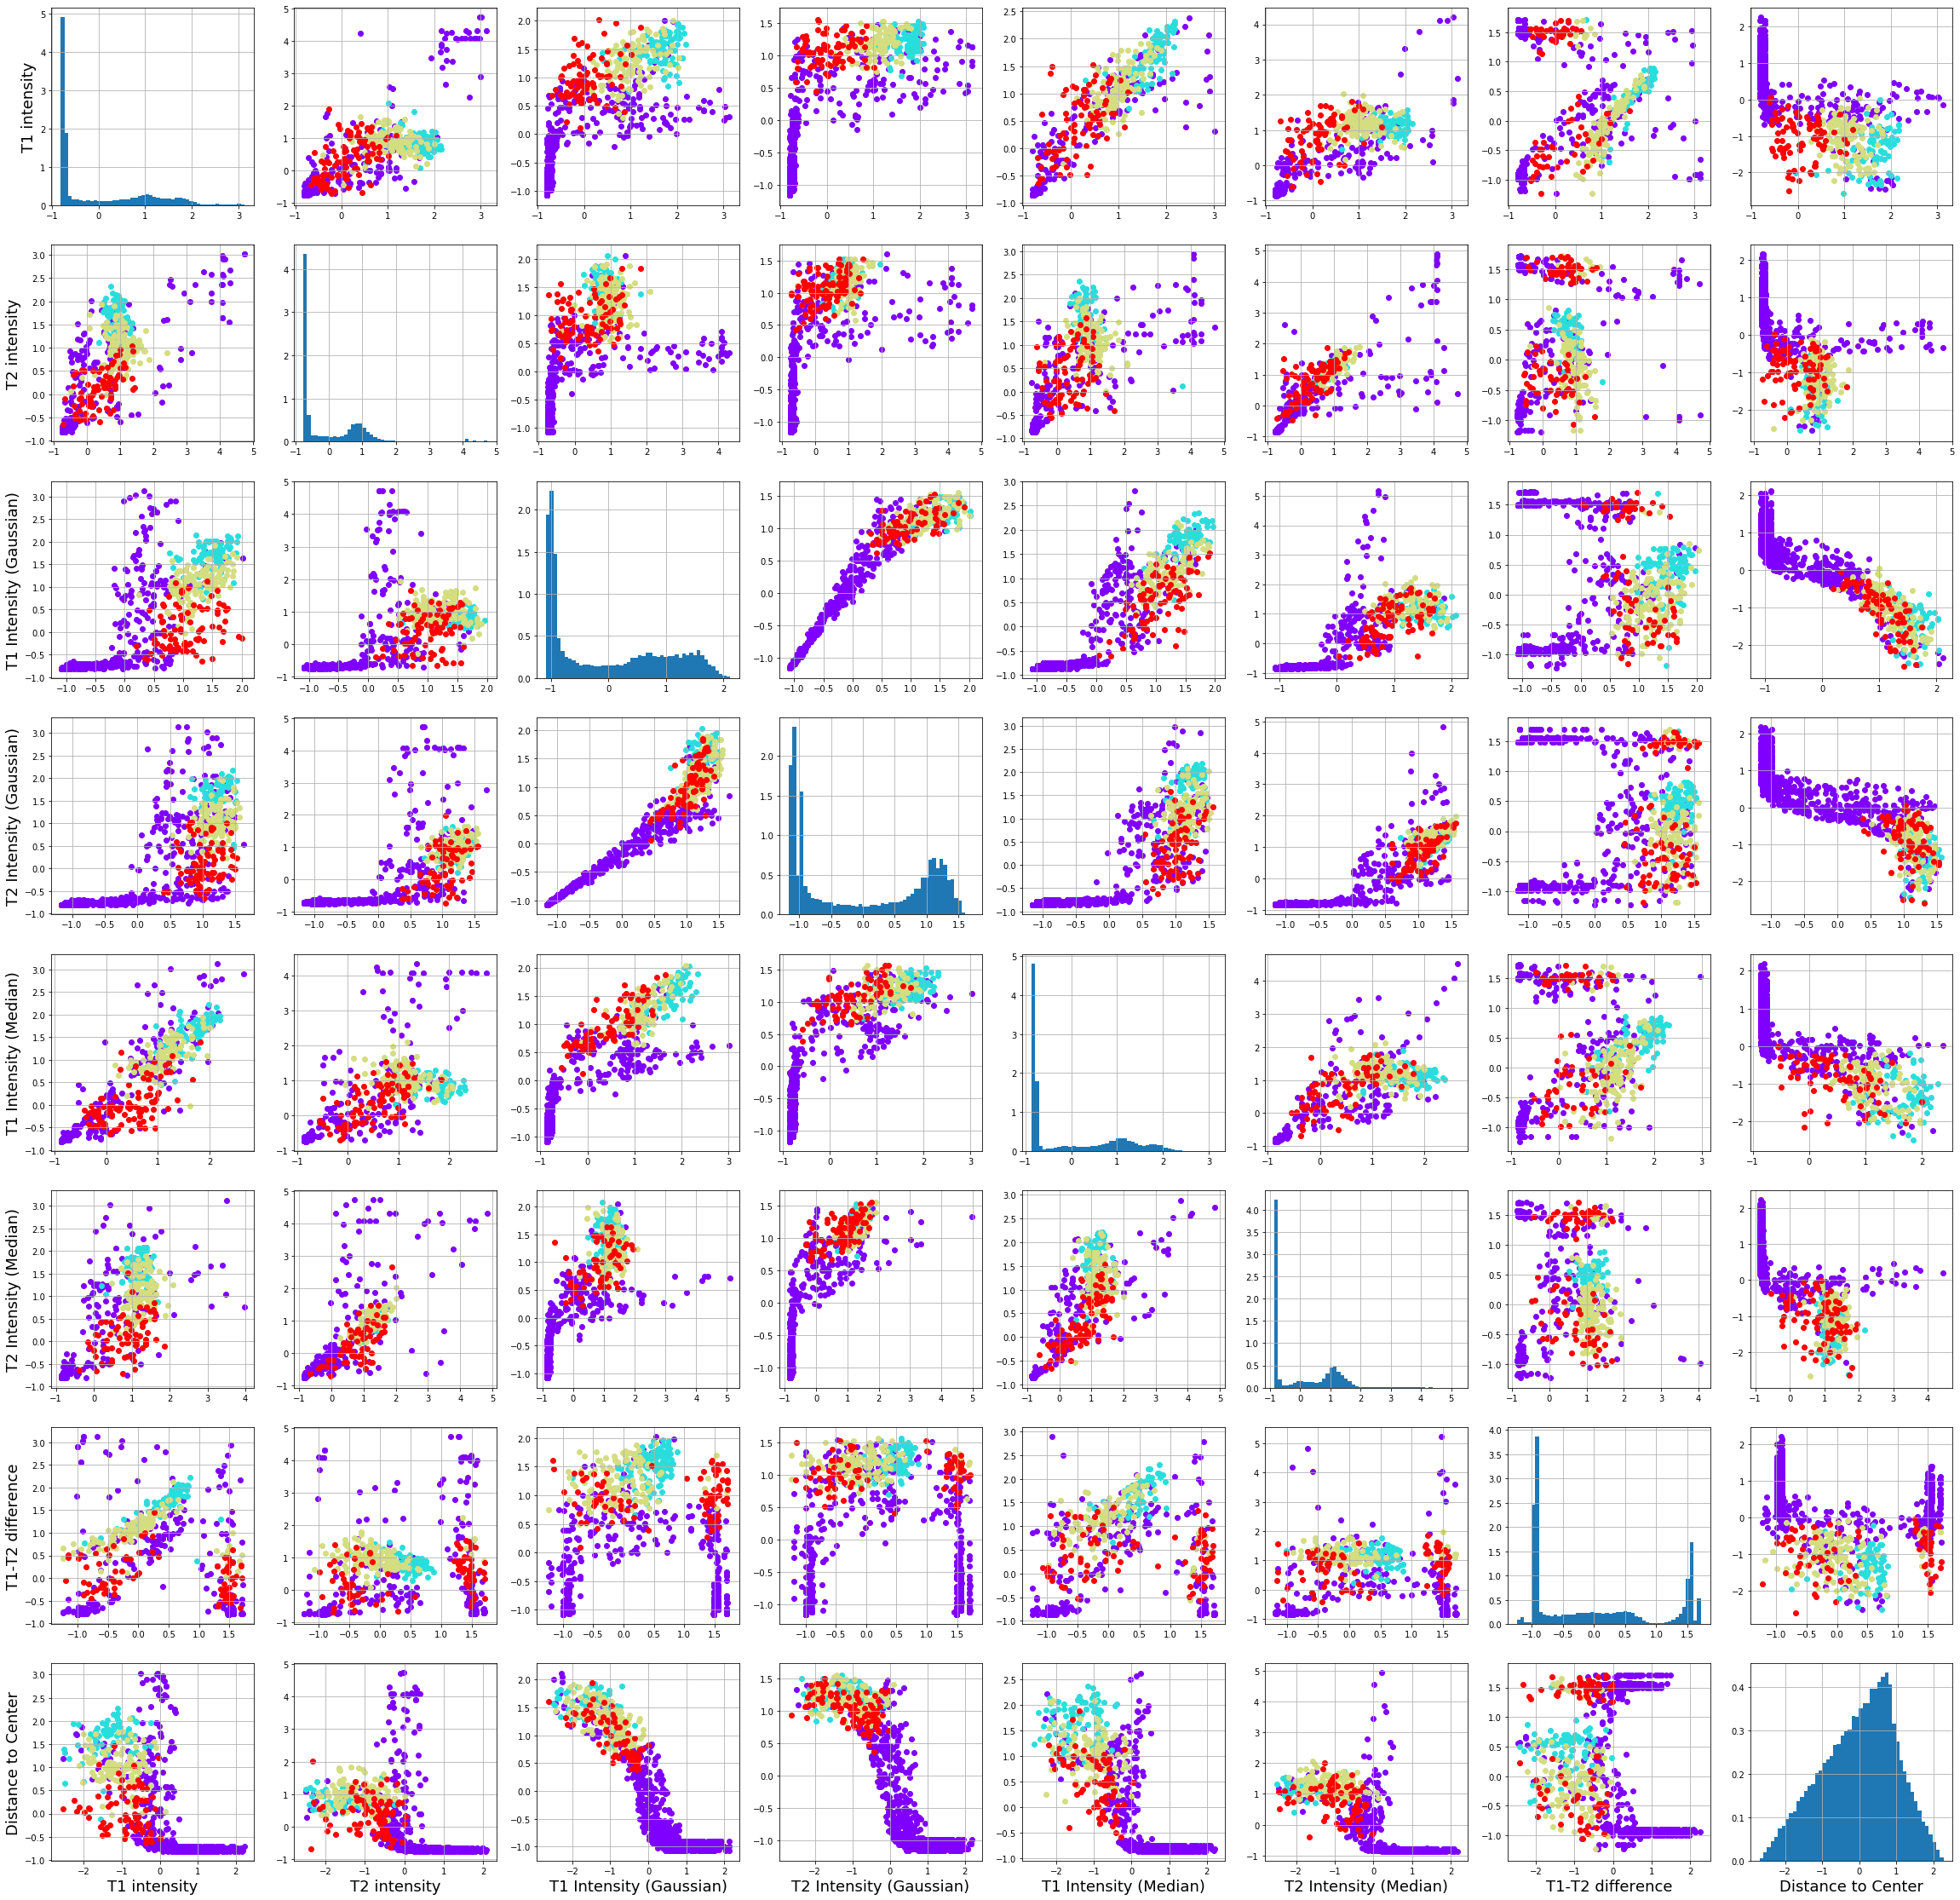

In [2]:
# Now, run the scatter matrix plot (seperated cell for - computing time - prototyping purposes)
%matplotlib inline
seg.scatter_all(data_norm,all_labels_matrix,tmp_feature_labels)

### 2. Model selection and generalization

1. Use the `create_dataset` function to create a training set and a test set for the tissue segmentation task. Use the same slice, but different subjects for training and testing.
2. Use these datasets to investigate using different features and different segmentation methods. You can use both classification error and dice overlap for evaluation, but since now there are four different classes (three tissues and background, you will need to use `dice_multiclass`.
    
    How do you decide what good choices are?  Document this process in a function you create yourself, which returns the best choices given two different subjects.
4. Repeat the above, but use a different subject for testing. Do your conclusions change or stay the same, why? What if you vary the slices? 

In [3]:
%matplotlib inline
import sys
sys.path.append("../code")
import matplotlib.pyplot as plt
import numpy as np
import segmentation_util as util
from scipy import stats
import segmentation as seg

## 0:T1, 1:T2, 2:T1gaus, 3:T2gaus, 4:T1 median, 5:T2 median, 6: T1-T2 difference, 7: distance to center
choice=[0,1,2,3,7]
I = plt.imread('../data/dataset_brains/1_1_t1.tif')

tslice = 1
trains=1
tests=2
ta='tissue'

train_data, train_labels, train_feature_labels = util.create_dataset(trains,tslice,ta)
test_data, test_labels, trest_feature_labels = util.create_dataset(tests,tslice,ta)

data_norm,test=seg.normalize_data(train_data,test_data)


In [4]:
## selecting specific features
train_data=train_data[:,choice]
test_data=test_data[:,choice]

In [5]:
# ## segmenting with kmeans_clustering
# if ta=='brain':
#     num_k=2
# else:
#     num_k=4
    
# predicted_labels=seg.kmeans_clustering(train_data, K=num_k)
# predicted_mask = predicted_labels.reshape(I.shape)
# fig = plt.figure(figsize=(15, 5))
# ax1 = fig.add_subplot(131)
# ax1.imshow(I)
# ax2 = fig.add_subplot(132)
# ax2.imshow(predicted_mask)
# ax3 = fig.add_subplot(133)
# ax3.imshow(train_labels.reshape(I.shape))

# dice_score = util.dice_multiclass(test_labels, predicted_labels)
# error = util.classification_error(test_labels, predicted_labels)

# print("Dice Score:\t",dice_score)
# print("Error:\t\t",error)

Dice Score:	 0.7552521086422125
Error:		 0.115


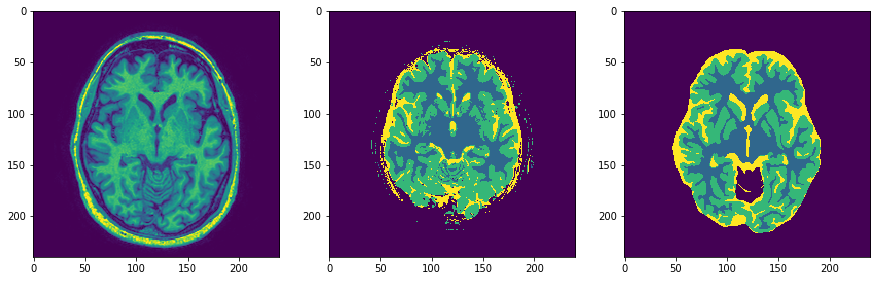

In [6]:
## segmenting with knn_clusering

ix = np.random.randint(len(train_data), size=1000)
train_datann = train_data[ix,:]
train_labelsnn = train_labels[ix,:]
test_labelsnn = test_labels[ix,:]

predicted_labels = seg.knn_classifier(train_datann,train_labelsnn,test_data,15)
predicted_mask = predicted_labels.reshape(I.shape)

predicted_labelsnn = predicted_labels[ix,:,0]


fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax1.imshow(I)
ax2 = fig.add_subplot(132)
ax2.imshow(predicted_mask)
ax3  = fig.add_subplot(133)
ax3.imshow(train_labels.reshape(I.shape))

dice_score = util.dice_multiclass(test_labelsnn, predicted_labelsnn)
error = util.classification_error(test_labelsnn, predicted_labelsnn)

print("Dice Score:\t",dice_score)
print("Error:\t\t",error)

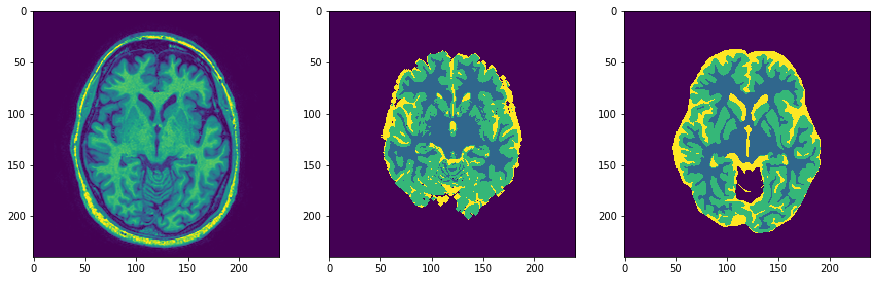

In [7]:
## Attempt at removing some of the inconsistencies due to the skull with an opening

openimage=scipy.ndimage.morphology.binary_opening(predicted_mask,iterations=2)
predicted_mask = predicted_mask*openimage

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax1.imshow(I)
ax2 = fig.add_subplot(132)
ax2.imshow(predicted_mask)
ax3  = fig.add_subplot(133)
ax3.imshow(train_labels.reshape(I.shape))


### 3. Combining different methods

1. Try the functions `segmentation_combined_atlas` and `segmentation_combined_knn` on the tissue segmentation task (do not forget to use majority voting for combining the labels). What are the strengths and weaknesses of each method?
2. Design a method that combines what you have learnt so far in `segmentation_mymethod`. Provide a motivation (based on what you know about the methods) of the choices that you made.
3. The script `segmentation_demo`, creates the results for several methods. This code is a bit slow, so it is not recommended to run it multiple times. (Also, you should not use all of these results to improve your method, since that means you are using the test data as the training data :) ). 
4. Run the script and look at the results. How does your method compare to the individual results? It is not required here that your method is always better! For example, you could select a subject where your method is the best, and a subject where your method is the worst, and explain what is happening in the images.
5. Discuss what other (combinations) methods could be suitable or not suitable for the task and why.

Loading data for 5 subjects...
Finished loading data.
Starting segmentation...


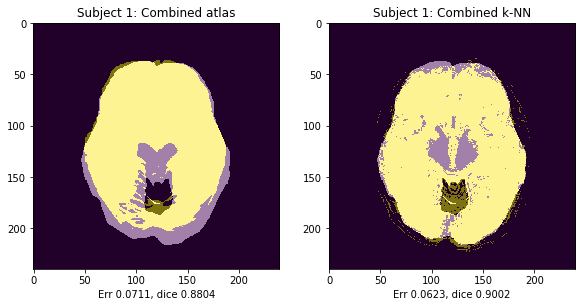

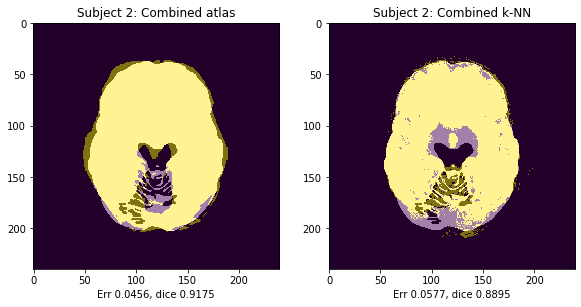

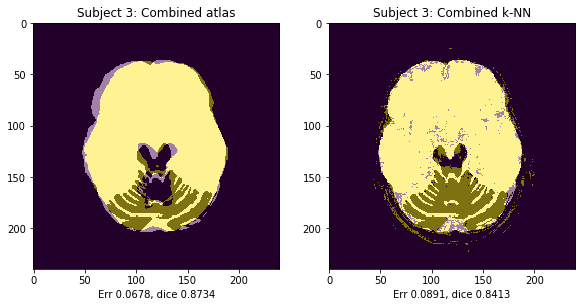

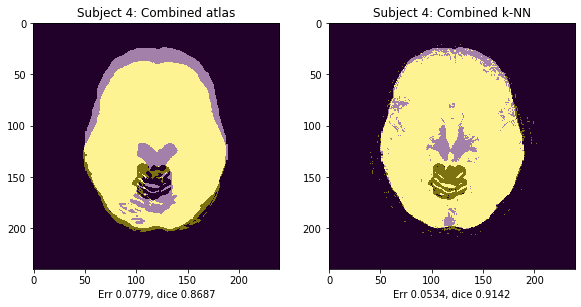

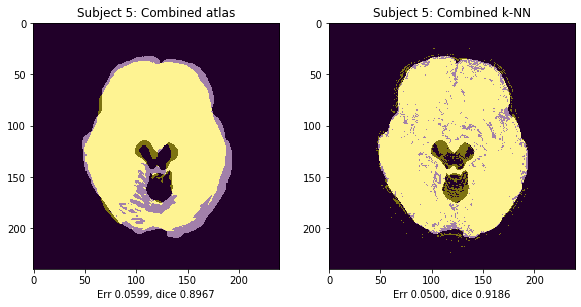

In [8]:
%matplotlib inline
import sys
sys.path.append("../code")
from segmentation_project import segmentation_demo
segmentation_demo()